# Used Car Prices

### Problem Statement

The aim of this project is to create regression model to help the new car trader company determine the price of used cars.

### Evaluation Metric
Mean squared error (𝑀𝑆𝐸)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

In [2]:
print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)
df.head()

The train dataset rows: 14032 , columns: 26 
(14032, 26)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,False,owned,front,True,False,False,False,False,False,False,False,False,False,7.0,4250.0
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,False,owned,front,False,True,False,False,False,False,False,False,False,False,133.0,4000.0
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,False,owned,front,False,False,False,True,False,False,True,True,True,True,0.0,10900.0
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,False,owned,front,False,True,True,False,False,True,False,False,True,True,20.0,6999.0
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,False,owned,front,False,False,False,False,False,False,False,False,False,True,160.0,1600.0


In [3]:
print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)
df_pred.head()

The test dataset rows: 7707 , columns: 25 
(7707, 25)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


### The Dataset
Each column in the dataset is labeled and explained in more detail below.  

<b>manufacturer_name:</b> the name of the car manufacturer  
<b>model_name:</b> the name of the car model  
<b>transmission:</b> the type of transmission the car has  
<b>color:</b> the body color of the car  
<b>odometer_value:</b> odometer state in kilometers  
<b>year_produced:</b> the year the car was produced  
<b>engine_fuel:</b> the fuel type of the engine of the car  
<b>engine_has_gas:</b> whether or not the car has a propane tank with tubing  
<b>engine_type:</b> the engine type of the car  
<b>engine_capacity:</b> capacity of the engine in liters  
<b>body_type:</b> the of body the car has  
<b>has_warranty:</b> whether the car has warranty  
<b>state:</b> the state of the car (new, owned, etc.)  
<b>drivetrain:</b> type of drivetrain (front, rear, all)  
<b>feature_1 - feature_9:</b> these features are boolean values about properties of the car  
<b>duration_listed:</b> the number of days the car is listed in the catalog  
<b>price_usd:</b> price of the car in USD  

### Dataset Files
public_cars.csv - Dataset to train and analyze  
pred_cars.csv - Dataset to predict cars prices

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14032 entries, 0 to 14031
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  14032 non-null  object 
 1   model_name         14032 non-null  object 
 2   transmission       14032 non-null  object 
 3   color              14032 non-null  object 
 4   odometer_value     14032 non-null  int64  
 5   year_produced      14032 non-null  int64  
 6   engine_fuel        14032 non-null  object 
 7   engine_has_gas     14032 non-null  bool   
 8   engine_type        14032 non-null  object 
 9   engine_capacity    14027 non-null  float64
 10  body_type          14032 non-null  object 
 11  has_warranty       14032 non-null  bool   
 12  state              14032 non-null  object 
 13  drivetrain         14031 non-null  object 
 14  feature_0          14031 non-null  object 
 15  feature_1          14031 non-null  object 
 16  feature_2          140

In [5]:
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

isnull_filter = df['price_usd'].isnull()
df[isnull_filter]

# Drop the row with missing price
missing_price = len(df[isnull_filter].index)
print('\nDropped rows with missing price: {} '.format(missing_price))
df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64

Dropped rows with missing price: 1 
Dataset: (14031, 26)

Missing values: 5


In [6]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#numeric_cols = df.drop('price_usd',axis=1).select_dtypes([np.int64,np.float64]).columns.tolist()
numeric_cols = df.drop('price_usd',axis=1).select_dtypes(numerics).columns.tolist()

#num = len(numeric_cols)
print ('Numeric: {} \n{}'.format(len(numeric_cols),numeric_cols))

categorical_cols = df.select_dtypes([np.object]).columns.tolist()
print ('Categorical: {} \n{}'.format(len(categorical_cols),categorical_cols))

booleans_cols = df.select_dtypes([np.bool]).columns.tolist()
print ('Boolean: {} \n{}'.format(len(booleans_cols), booleans_cols))

Columns
Numeric: 4 
['odometer_value', 'year_produced', 'engine_capacity', 'duration_listed']
Categorical: 19 
['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_type', 'body_type', 'state', 'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
Boolean: 2 
['engine_has_gas', 'has_warranty']


In [7]:
# Copy the original dataset before transformation
df_origin = df.copy()

### Utility functions

In [8]:
def get_skewness_kurtosis(feature):
    """ Calculates and prints skewness and kurtosis of feature. """
    skew = df[feature].skew()
    kurt = df[feature].kurt()
    print("Skewness: {}".format(skew))
    print("Kurtosis: {}".format(kurt))

#### Target variable

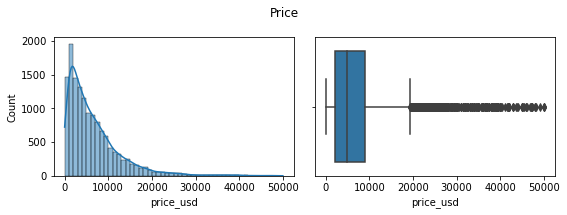

In [9]:
# Plot histograms to see if the target variable is normally distributed
variable = 'price_usd'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df[variable], ax=ax2)

fig.suptitle('Price')
plt.tight_layout()

In [10]:
# Find skewness and kurtosis of feature
get_skewness_kurtosis('price_usd')

Skewness: 2.2126696601911853
Kurtosis: 7.160755604802766


In [11]:
,

99.5% percentile: $37879.59
Mean: $6617.33
Median: $4800.0


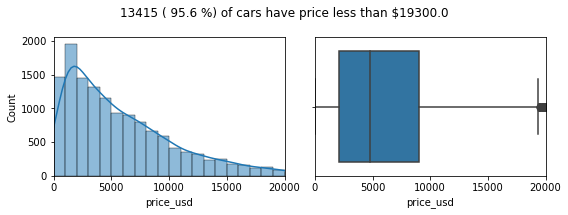

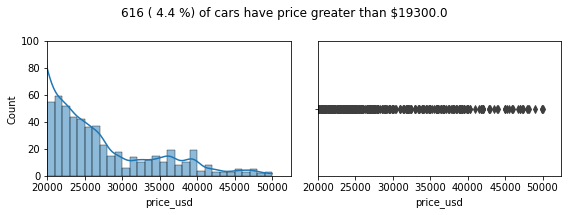

In [12]:
# Figure out top limit for outliers
IQR = df[variable].quantile(.75) - df[variable].quantile(.25)
limit_price = df[variable].quantile(.75) + 1.5*IQR
limit_price = round(limit_price,-2)

price = len(df[df[variable] <= limit_price]) 
percent = round( price / len(df[variable])*100, 1)

# Plot histograms to see if the target variable is normally distributed
variable = 'price_usd'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df[variable], ax=ax2)
ax1.set_xlim(0,20000)
ax2.set_xlim(0,20000)

fig.suptitle("{} ( {} %) of cars have price less than ${}".format(price, percent, limit_price))
plt.tight_layout()

# Find the percent of outliers with high price
outliers = len(df[df[variable] > limit_price]) 
percent = round( outliers / len(df[variable])*100, 1)

# Plot histogram
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df[variable], ax=ax2)
ax1.set_xlim(20000,)
ax1.set_ylim(0,100)
ax2.set_xlim(20000,)

fig.suptitle("{} ( {} %) of cars have price greater than ${}".format(outliers, percent, limit_price))
plt.tight_layout()

In [13]:
df[variable].describe()

count    14031.000000
mean      6617.332204
std       6362.497453
min          1.000000
25%       2100.000000
50%       4800.000000
75%       8999.000000
max      50000.000000
Name: price_usd, dtype: float64

#### Predictor variables

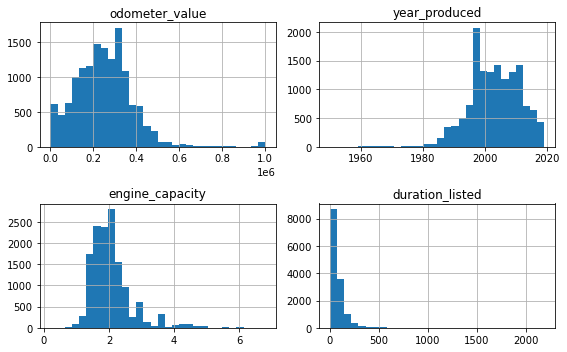

In [14]:
# Plot histograms of predictor variables
df[numeric_cols].hist(figsize=(8,5), bins=30)
plt.tight_layout()

In [15]:
# Find skewness and kurtosis of features
for feature in numeric_cols:
    print(" '{}' ".format(feature))
    get_skewness_kurtosis(feature)

 'odometer_value' 
Skewness: 1.112737760154223
Kurtosis: 4.695961053487939
 'year_produced' 
Skewness: -0.43164240406706367
Kurtosis: 0.8743047346070751
 'engine_capacity' 
Skewness: 1.9809791953266271
Kurtosis: 5.79106588515822
 'duration_listed' 
Skewness: 7.044705370822806
Kurtosis: 76.90519517446654


#### Observation

The target variable and predictor variables are not normally distributed.  
The variables are  right-skewed, except 'year_produced'.  
There are multiple outliers in the variables. 'duration_listed' variable has extreme outliers.

It will be fixed by using different types of transformation.

In [16]:
# Get the correlation of numeric features with target variable 
corr = df[numeric_cols + ['price_usd']].corr()
corr['price_usd'].drop('price_usd').sort_values(ascending = False)

year_produced      0.706632
engine_capacity    0.282424
duration_listed    0.029640
odometer_value    -0.417590
Name: price_usd, dtype: float64

#### Predictor variables

In [17]:
# Find out unique manufactures
manufacturers = df['manufacturer_name'].unique()
print('Unique manufacturers:  {}'.format(len(manufacturers)))
print(manufacturers)

# Find out the most common and the least common car manufactures
df_manufacturers = pd.DataFrame(df['manufacturer_name'].value_counts()).reset_index()
df_manufacturers.columns=['Manufacturer', 'Count']

Unique manufacturers:  55
['Ford' 'Dodge' 'Mazda' 'Audi' 'Volkswagen' 'Opel' 'Volvo' 'Peugeot'
 'Renault' 'Honda' 'Toyota' 'Mercedes-Benz' 'Citroen' 'Hyundai' 'ВАЗ'
 'Skoda' 'BMW' 'Kia' 'Fiat' 'Chrysler' 'Mitsubishi' 'Rover' 'Chevrolet'
 'Nissan' 'Lifan' 'LADA' 'Jaguar' 'УАЗ' 'Seat' 'Buick' 'Land Rover'
 'Porsche' 'Suzuki' 'Alfa Romeo' 'Daewoo' 'Mini' 'Subaru' 'Lexus' 'Saab'
 'ГАЗ' 'Lancia' 'Pontiac' 'Geely' 'Acura' 'Jeep' 'Chery' 'Infiniti'
 'SsangYong' 'Dacia' 'ЗАЗ' 'Great Wall' 'Lincoln' 'Cadillac' 'Iveco'
 'Москвич']


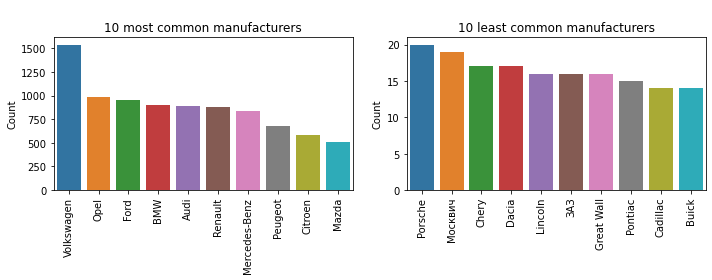

In [18]:
# Create bar plots of categorical variables
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
x_df = df_manufacturers[:10]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=ax1)

x_df= df_manufacturers[len(df_manufacturers)-10:]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=ax2)

ax1.xaxis.set_tick_params(rotation=90)
ax2.xaxis.set_tick_params(rotation=90)

ax1.set_title('\n10 most common manufacturers')
ax2.set_title('\n10 least common manufacturers')

ax1.set_xlabel('')
ax2.set_xlabel('')

plt.tight_layout()

Unique models:  928


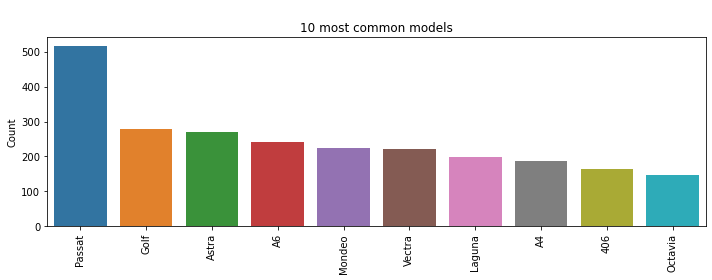

In [19]:
# Find out unique manufactures
models = df['model_name'].unique()
print('Unique models:  {}'.format(len(models)))
#print(models)

# Find out the most common and the least common car manufactures
df_models = pd.DataFrame(df['model_name'].value_counts()).reset_index()
df_models.columns=['Model', 'Count']

# Create bar plots of categorical variables
fig, ax1 = plt.subplots(ncols=1,nrows=1,figsize=(10,4))
x_df = df_models[:10]
sns.barplot(x='Model', y='Count', data=x_df, ax=ax1)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title('\n10 most common models')
ax1.set_xlabel('')

plt.tight_layout()

In [20]:
# Create 'name' variable to combine manufacture and model names
columns_strip = ['manufacturer_name', 'model_name']
# Delete extra space in strings
for column in columns_strip:
    df[column] = df[column].apply(lambda x: x.strip())
# Combine manufacture and model names    
df['name'] = df['manufacturer_name'] + ' ' + df['model_name']

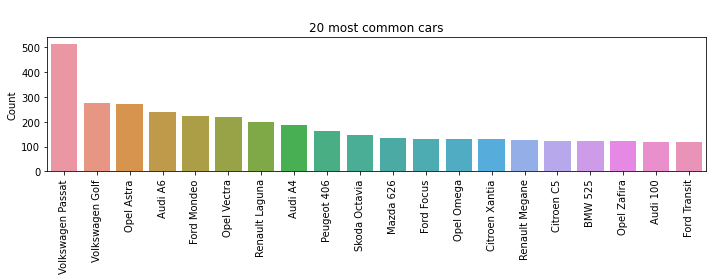

In [21]:
# Find out the most common and the least common car manufactures
df_cars = pd.DataFrame(df['name'].value_counts()).reset_index()
df_cars.columns=['Car', 'Count']

# Create bar plots of categorical variables
fig, ax1 = plt.subplots(ncols=1,nrows=1,figsize=(10,4))
x_df = df_cars[:20]
sns.barplot(x='Car', y='Count', data=x_df, ax=ax1)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title('\n20 most common cars')
ax1.set_xlabel('')

plt.tight_layout()

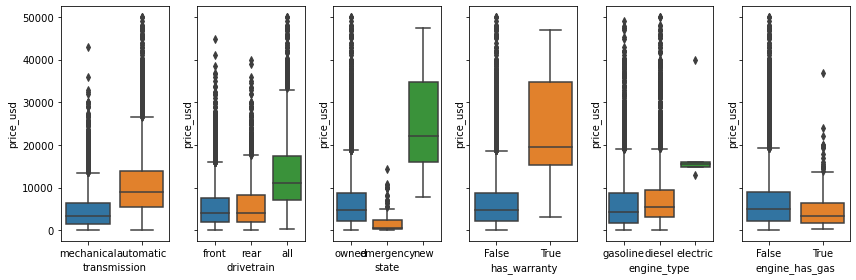

In [22]:
# Create box plots of categorical variables
categor_cols = ['transmission','drivetrain', 'state', 'has_warranty', 'engine_type', 'engine_has_gas']
fig, axes = plt.subplots(ncols=len(categor_cols),nrows=1,figsize=(12,4), sharey=True)
for index,column in enumerate(categor_cols):
    sns.boxplot(x=column,y='price_usd',data=df, ax=axes[index])
plt.tight_layout()

In [23]:
# Count unique values
for column in categor_cols:
    print(pd.DataFrame(df[column].value_counts()))

            transmission
mechanical          9289
automatic           4742
       drivetrain
front       10094
all          1980
rear         1957
           state
owned      13726
new          168
emergency    137
       has_warranty
False         13869
True            162
          engine_type
gasoline         9396
diesel           4630
electric            5
       engine_has_gas
False           13526
True              505


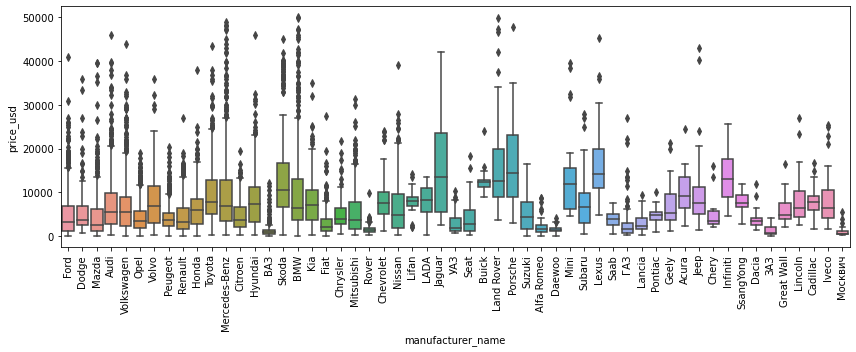

In [24]:
# Create box plots of categorical variables
categor_cols = 'manufacturer_name'
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=categor_cols,y='price_usd',data=df, ax=ax)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()

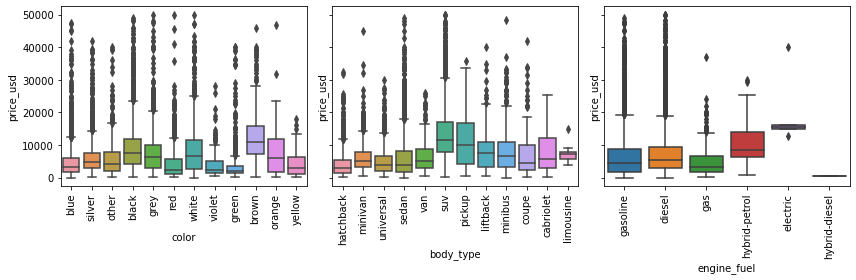

In [25]:
# Create box plots of categorical variables
categor_cols = ['color', 'body_type', 'engine_fuel']
fig, (ax1, ax2, ax3) = plt.subplots(ncols=len(categor_cols),nrows=1,figsize=(12,4), sharey=True)
sns.boxplot(x=categor_cols[0],y='price_usd',data=df, ax=ax1)
sns.boxplot(x=categor_cols[1],y='price_usd',data=df, ax=ax2)
sns.boxplot(x=categor_cols[2],y='price_usd',data=df, ax=ax3)
ax1.xaxis.set_tick_params(rotation=90)
ax2.xaxis.set_tick_params(rotation=90)
ax3.xaxis.set_tick_params(rotation=90)
plt.tight_layout()

In [26]:
# Count unique values
for column in categor_cols:
    print(pd.DataFrame(df[column].value_counts()))

        color
black    2766
silver   2525
blue     2077
white    1578
grey     1373
red      1062
green    1024
other     962
brown     325
violet    169
yellow    114
orange     56
           body_type
sedan           4746
hatchback       2799
universal       1963
suv             1903
minivan         1287
minibus          517
van              275
coupe            241
liftback         216
pickup            50
cabriolet         26
limousine          8
               engine_fuel
gasoline              8801
diesel                4629
gas                    505
hybrid-petrol           90
electric                 5
hybrid-diesel            1


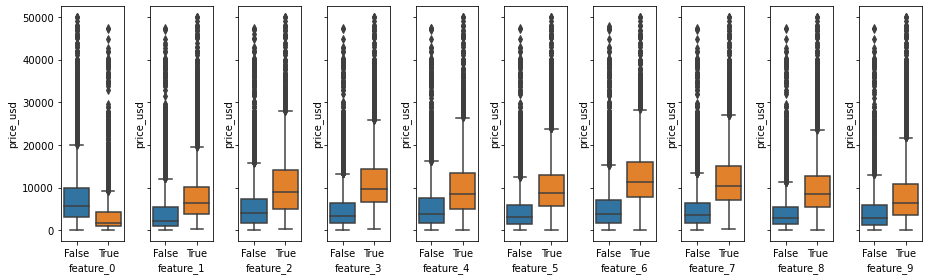

In [27]:
# Create box plots of categorical variables
categor_cols = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
                      'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']

fig, axes = plt.subplots(ncols=len(categor_cols), nrows=1, figsize=(13,4), sharey=True )
for index,column in enumerate(categor_cols):
    sns.boxplot(x=column,y='price_usd',data=df, ax=axes[index])
    ax.set_ylabel('')
        
plt.tight_layout()

In [28]:
# Count unique values
values = pd.DataFrame()
for column in categor_cols:
    print(pd.DataFrame(df[column].value_counts()))

       feature_0
False      10802
True        3229
       feature_1
True        8507
False       5524
       feature_2
False      10852
True        3179
       feature_3
False      10139
True        3892
       feature_4
False      10650
True        3381
       feature_5
False       9095
True        4936
       feature_6
False      11663
True        2368
       feature_7
False      10390
True        3641
       feature_8
False       8238
True        5793
       feature_9
True        8070
False       5961


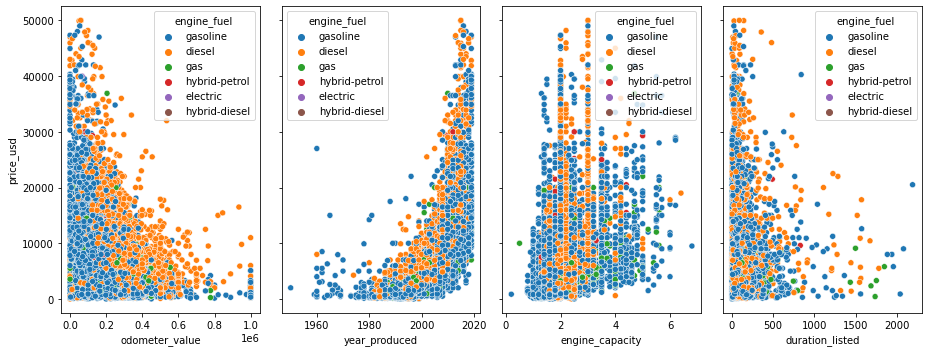

In [29]:
# Check linear relationship between the dependent variable and the independent variables
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,5), sharey=True)
for index,column in enumerate(numeric_cols):
    sns.scatterplot(x=column,y='price_usd',data=df, hue='engine_fuel', ax=axes[index])
    
plt.tight_layout()

### Regression Assumptions

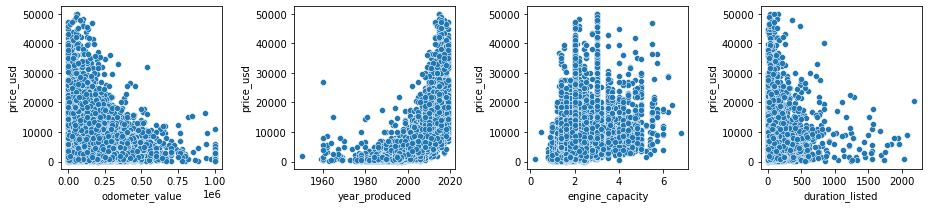

In [30]:
# Check linear relationship between the dependet variable and the independent variables
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,3))
for index,column in enumerate(numeric_cols):
    sns.scatterplot(x=column,y='price_usd',data=df, ax=axes[index])
    
plt.tight_layout()

### Dealing with outliers

In [31]:
# Drop electric cars
electric_cars = df['engine_type'] == 'electric'
electric = df[electric_cars]

# Remove prices over the 99.5% percentile
quantile = df['price_usd'].quantile(0.995)
price_quantile = df['price_usd'] > quantile
price = df[price_quantile]

outliers = df[(electric_cars | price_quantile )]

# Save the rows with outliers to csv file
fl = "4. Analysis/used_car_prices_outliers.csv"
outliers.to_csv(fl, index=False)

print('Dataset: {}'.format(df.shape))
df.drop( outliers.index, inplace=True)
df.reset_index(drop=True, inplace=True)
print('Dropped rows with electric cars: {} '.format(len(electric)))
print('\n0.995 quantile: {}'.format(quantile))
print('Drop prices over the 99.5% percentile: {}'.format(len(price)))
print('Dataset: {}'.format(df.shape))

Dataset: (14031, 27)
Dropped rows with electric cars: 5 

0.995 quantile: 37879.58800000005
Drop prices over the 99.5% percentile: 71
Dataset: (13956, 27)


In [32]:
# Drop extreme outliers
# Copy an original dataset
df_origin = df.copy()

# Create filters to locate extreme outliers
# Categorical features
mask1=(df['transmission'] == 'mechanical') & (df['price_usd']>35000)
mask2=(df['drivetrain'] != 'all') & (df['price_usd']>37000)
mask3=(df['state'] == 'emergency') & (df['price_usd']>12000)
mask4=(df['engine_has_gas'] == True) & (df['price_usd']>30000)
# Numerical features
mask5=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask6=(df['odometer_value'] > 400000) & (df['price_usd']>20000)
mask7=(df['odometer_value'] > 800000) & (df['price_usd']>9000)
mask8=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask9=(df['year_produced'] < 1960) 
mask10=((df['engine_capacity'] < 0.8) | (df['engine_capacity'] > 6.2) )
mask11=(df['duration_listed']==df['duration_listed'].max())
mask12=(df['price_usd'] < 100) | (df['price_usd'] > 37000)

# Combine all filters
outliers = df[mask1|mask2|mask3| mask4|mask5|mask6|mask7|mask8|mask9|mask10|mask11|mask12]
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_extreme_outliers.csv"
outliers.to_csv(fl, index=False)

print("Dataset: {}".format(df.shape))
df.drop( outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape))

Dataset: (13956, 27)
Drop 32 outliers
Dataset: (13924, 27)


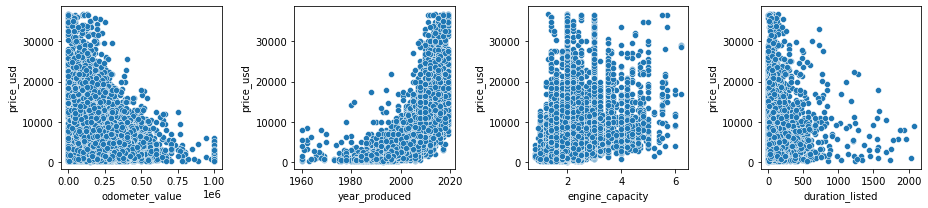

In [33]:
# Check linear relationship between the dependet variable and the independent variables after dropping outliers
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,3))
for index,column in enumerate(numeric_cols):
    sns.scatterplot(x=column,y='price_usd',data=df, ax=axes[index])

plt.tight_layout()

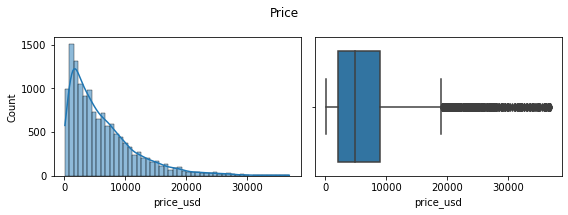

In [34]:
# Plot histograms to see if the target variable is normally distributed
variable = 'price_usd'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df[variable], ax=ax2)

fig.suptitle('Price')
plt.tight_layout()

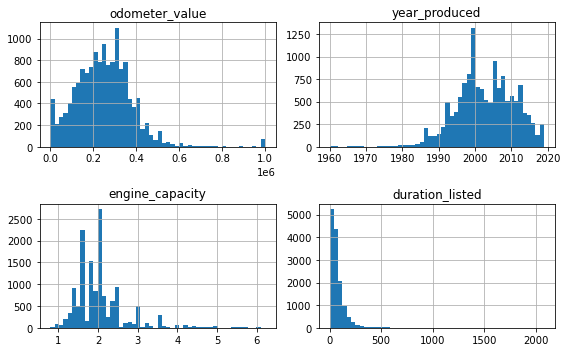

In [35]:
# Plot histograms of predictor variables
df[numeric_cols].hist(figsize=(8,5), bins=50)
plt.tight_layout()

In [36]:
# Create a feature that represents mileage per year
df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

# Create copy of data
df_tr = df.copy()

### Evaluate impact of transformations on the data distribution

In [37]:
# Transform target and predictor variables using Yeo-Johnson transformation
columns = ['price_usd','odometer_value', 'duration_listed']


power = PowerTransformer(method='yeo-johnson')
df_tr[columns] = power.fit_transform(df_tr[columns])

# Transform predictor variables using Quantile Transformer
columns = ['engine_capacity', 'year_produced']

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
df_tr[columns] = qt.fit_transform(df_tr[columns])

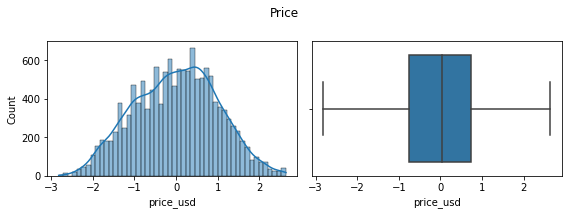

In [38]:
# Plot histograms to see if the target variable is normally distributed
variable = 'price_usd'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df_tr[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df_tr[variable], ax=ax2)

fig.suptitle('Price')
plt.tight_layout()

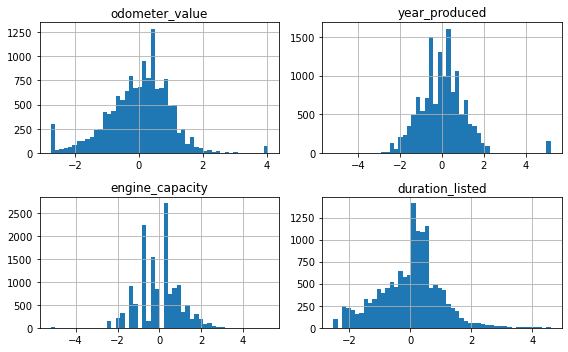

In [39]:
# Plot histograms of predictor variables
df_tr[numeric_cols].hist(figsize=(8,5), bins=50)
plt.tight_layout()

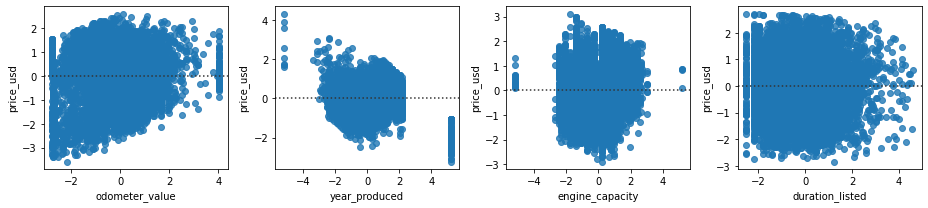

In [40]:
# Check homoscedasticity after transformation
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(13,3))
for index,column in enumerate(numeric_cols):
    sns.residplot(x=column,y='price_usd',data=df_tr, ax=axes[index])
        
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix')

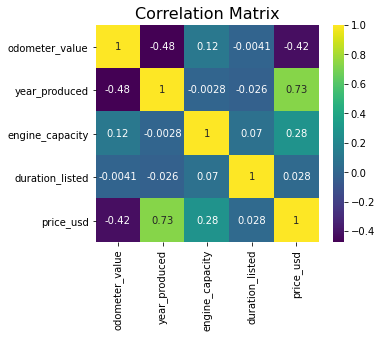

In [41]:
# Check no or little correlation between independent variables
corr = df[numeric_cols + ['price_usd']].corr()

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(corr,annot=True,cmap='viridis')
plt.title('Correlation Matrix', fontsize=fontsize) 

## Preprocessing data

### Dealing with missing values

In [42]:
# Find out missing values
df[df['engine_capacity'].isnull()]

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd,name,odometer_value/year,year


#### Observation

The missing values will be by filled using SimpleImputer strategy in ColumnTransformer of Pipeline.

### Feature engineering

In [43]:
# Create a class to transform columns 
class FeatureEngineering(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        df = X
        
        # Create 'name' variable to combine manufacture and model names
        columns_strip = ['manufacturer_name', 'model_name']
        # Delete extra space in strings
        for column in columns_strip:
            df[column] = df[column].apply(lambda x: x.strip())
        # Combine manufacture and model names    
        df['name'] = df['manufacturer_name'] + ' ' + df['model_name']

        # Create a feature that represents mileage per year
        df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
        # Create a feature how old is a car
        df['year'] = 2020 - df['year_produced']

        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 6
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['name'] < car_total].index
        # create a new category'other' for rare car model names
        df['name'] = df['name'].apply(lambda x: 'other' if x in car_models_list else x)

        # Create features to reduce a number of categories
        hybrid ='hybrid_or_electric'
        df['engine_fuel'] = df['engine_fuel'].replace({'hybrid-petrol':hybrid,'hybrid-diesel':hybrid,'electric':hybrid})

        # Create a list of unnamed features
        features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
        # Count a total number of unnamed features for a car
        df['other_features']=df[features_list].sum(axis=1)
        
        global feats
        feats = ['name', 'odometer_value/year', 'year', 'other_features'] 
        
        return X

# Create a pipeline for feature engineering
feature_engineering = Pipeline(steps=
                               [('features', FeatureEngineering())
                               ])

# Create new features using the pipeline
df=feature_engineering.fit_transform(df)

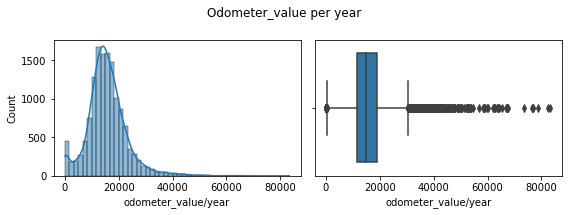

In [44]:
# Plot histograms to see if the predictor variable is normally distributed
variable = 'odometer_value/year'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df[variable], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df[variable], ax=ax2)

fig.suptitle('Odometer_value per year')
plt.tight_layout()

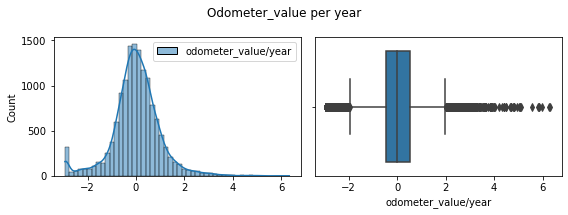

In [45]:
df_tr = df.copy()
columns = ['odometer_value/year']

power = PowerTransformer(method='yeo-johnson')
df_tr[columns] = power.fit_transform(df_tr[columns])

# Plot histograms to see if the predictor variable is normally distributed
variable = 'odometer_value/year'
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=df_tr[columns], kde=True, bins=50, ax=ax1)
sns.boxplot(x=df_tr[variable], ax=ax2)

fig.suptitle('Odometer_value per year')
plt.tight_layout()

### Feature selection

In [46]:
df.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'feature_9', 'duration_listed', 'price_usd', 'name',
       'odometer_value/year', 'year', 'other_features'],
      dtype='object')

In [47]:
# Define predictor and target variables
features =[ 'manufacturer_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'name',
           'odometer_value', 'odometer_value/year', 'year',  'engine_fuel','color',
           'duration_listed', 'body_type', 'engine_capacity', 'other_features', 'feature_0',
           
           #'year_produced', 'engine_type',
           #'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
           #'feature_6', 'feature_7', 'feature_8', 'feature_9'           
           ]

target = 'price_usd'

data = df[features+ [target]].copy()
print('Dataset: {}'.format(data.shape))

Dataset: (13924, 17)


In [48]:
data.head()

,manufacturer_name,has_warranty,state,drivetrain,transmission,name,odometer_value,odometer_value/year,year,engine_fuel,color,duration_listed,body_type,engine_capacity,other_features,feature_0,price_usd
0,Ford,False,owned,front,mechanical,Ford Fusion,245000,17500.0,14,gasoline,blue,7.0,hatchback,1.6,1.0,True,4250.0
1,Dodge,False,owned,front,automatic,Dodge Caravan,265542,14752.0,18,gasoline,silver,133.0,minivan,3.3,1.0,False,4000.0
2,Ford,False,owned,front,mechanical,Ford Galaxy,168000,15273.0,11,diesel,blue,0.0,minivan,1.8,5.0,False,10900.0
3,Mazda,False,owned,front,mechanical,Mazda 6,225522,18794.0,12,gasoline,other,20.0,universal,1.8,5.0,False,6999.0
4,Audi,False,owned,front,mechanical,Audi 80,370000,12759.0,29,gasoline,black,160.0,sedan,1.8,1.0,False,1600.0


## Model

In [49]:
data.columns

Index(['manufacturer_name', 'has_warranty', 'state', 'drivetrain',
       'transmission', 'name', 'odometer_value', 'odometer_value/year', 'year',
       'engine_fuel', 'color', 'duration_listed', 'body_type',
       'engine_capacity', 'other_features', 'feature_0', 'price_usd'],
      dtype='object')

### Transform the target variable

In [50]:
# Copy the initial dataset before transformation
df_origin = data.copy()

# Create features and target from the data set
X = data.drop(target ,axis=1)
y = data[target]

# Reshape target variable
y = np.array(y).reshape(-1,1)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Transform the target variable
power_tr = PowerTransformer(method='yeo-johnson')
power_tr.fit(y_train)

y_train = power_tr.transform(y_train)
y_test = power_tr.transform(y_test)

y_train = y_train.ravel()
y_test = y_test.ravel()

### Create pipeline

In [51]:
# Numeric data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Print numeric features
numeric_features = X.select_dtypes(numerics).columns.tolist()
print('Numeric features: {}'.format(numeric_features))


# Applies Power Transformer using Yeo-Johnson transformation to numeric columns 
numeric_power = ['odometer_value',  'odometer_value/year', 'duration_listed']

numeric_power_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('power', PowerTransformer(method='yeo-johnson')),
                                     ('scaler', StandardScaler())
                                    ])

# Applies Quantile Transformer to numeric columns 
numeric_quantile = ['engine_capacity', 'year', 'other_features']

numeric_quantile_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('quantile', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
                                     ('scaler', StandardScaler())
                                    ])


# Print categorical features
categorical_features = X.select_dtypes([np.object,np.bool]).columns.tolist()
print('Categorical features: {}'.format(categorical_features))

# Transform categorical columns using OneHotEncoder
categorical_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                     ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

# Create ColumnTransformer to perform different transformations for different columns of the data
preprocessor = ColumnTransformer(transformers=
                                     [('num_power', numeric_power_transformer, numeric_power),
                                      ('num_qt', numeric_quantile_transformer, numeric_quantile),
                                      ('cat', categorical_transformer, categorical_features)
                                     ])


Numeric features: ['odometer_value', 'odometer_value/year', 'year', 'duration_listed', 'engine_capacity', 'other_features']
Categorical features: ['manufacturer_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'name', 'engine_fuel', 'color', 'body_type', 'feature_0']


### Model selection

In [52]:
######################################### Linear Regression model ######################################
# Create an instance of a model
model = LinearRegression()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_1 = score
mse_1 = mse

LinearRegression()
Score: 0.8859815126992578
MSE: -0.12855824252198284


In [53]:
######################################### LassoCV model ######################################
# Create an instance of a model
model = LassoCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

#y_train = y_train.ravel()
#y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_2 = score
mse_2 = mse

LassoCV()
Score: 0.8666095326906127
MSE: -0.13360939129708033


In [54]:
######################################### RidgeCV model ######################################
# Create an instance of a model
model = RidgeCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_3 = score
mse_3 = mse

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
Score: 0.8870155684318175
MSE: -0.12134557626484879


In [55]:
######################################### Gradient Boosting Regressor model ######################################
# Create an instance of a model
model = GradientBoostingRegressor()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()
y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_4 = score
mse_4 = mse

GradientBoostingRegressor()
Score: 0.8896722445519599
MSE: -0.1173228093899175


In [56]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()
y_test = y_test.ravel()

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_5 = score
mse_5 = mse 

SVR()
Score: 0.9161300352697478
MSE: -0.09730792273020634


In [57]:
# Compare results in one table
model_names = ['Linear Regression','LassoCV','RidgeCV','Gradient Boosting Regressor', 'SVR']
score = [score_1, score_2, score_3, score_4, score_5]
mse = [mse_1, mse_2, mse_3, mse_4, mse_5]

table = {'Score': score, 'MSE': mse}

table_df = pd.DataFrame(data=table, index=model_names)
table_df

,Score,MSE
Linear Regression,0.885982,-0.128558
LassoCV,0.866610,-0.133609
RidgeCV,0.887016,-0.121346
Gradient Boosting Regressor,0.889672,-0.117323
SVR,0.916130,-0.097308


### Model tuning

In [58]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()


################################### GridS earch ###########################################
param_grid = {'model__C': [0.1, 0.5, 1, 2, 5]}
search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train) 

#print('The best estimator: {}'.format(search.best_estimator_))
print('The best parameters: {}'.format(search.best_params_))
print('The best score: {}'.format(search.best_score_))

SVR()
The best parameters: {'model__C': 2}
The best score: 0.9158292342501166


### Final model

In [59]:
######################################### SVR model ######################################
# Create an instance of a model
model = search.best_estimator_['model']
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))


SVR(C=2)
Score: 0.9164137194629518
MSE: -0.09723680110929891


In [60]:
y_predict_test_price = power_tr.inverse_transform(y_predict_test.reshape(-1,1))
y_predict_test_price_round = np.round(y_predict_test_price,-2)
results = pd.DataFrame( {'Actual transformed':y_test.reshape(-1), 'Predicted':y_predict_test.reshape(-1),
                         'Predicted inverse transformed':y_predict_test_price.reshape(-1), 
                         'Predicted inverse transformed rounded':y_predict_test_price_round.reshape(-1)},
                       index=X_test.index)

results = results.join(df_origin['price_usd'], how ='left')
results.rename(columns={'price_usd':'Actual'}, inplace=True)

print('Car Prices')
results.head(10)

Car Prices


,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
4034,0.556913,0.716513,8833.194533,8800.0,7700.0
5503,0.313621,0.366698,6505.252841,6500.0,6200.0
519,0.980613,1.501817,16526.817986,16500.0,11000.0
8577,1.499655,1.604739,17844.042289,17800.0,16500.0
4025,-1.782147,-2.407063,208.940460,200.0,569.1
11263,-1.587110,-1.091655,1422.852365,1400.0,750.0
10626,-0.942516,-0.919711,1745.952145,1700.0,1700.0
930,-1.540876,-1.642639,694.370238,700.0,799.0
1238,1.682922,1.370060,14955.834672,15000.0,18900.0
1827,0.348627,0.781472,9331.138376,9300.0,6400.0


In [61]:
results.tail(10)

,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
4439,0.980613,0.868641,10034.541152,10000.0,11000.0
8843,-0.917726,-0.753201,2112.618563,2100.0,1750.0
7028,-0.446123,-0.638757,2398.710794,2400.0,2950.0
11013,-0.529885,-0.200454,3796.233277,3800.0,2699.0
8732,-0.098536,0.182549,5495.276077,5500.0,4200.0
6935,-1.229603,-0.964518,1656.589952,1700.0,1200.0
3095,-0.638266,-0.823547,1950.842764,2000.0,2400.0
5616,0.802868,0.798902,9468.515669,9500.0,9500.0
3154,-0.353218,-0.762426,2090.809659,2100.0,3250.0
10558,-0.801691,-1.258510,1157.071404,1200.0,2000.0


In [62]:
mse = mean_squared_error(results['Actual'], results['Predicted inverse transformed'])
print('MSE: {}'.format(mse))

MSE: 2699243.0300397


Text(0.5, 0, 'Car Price')

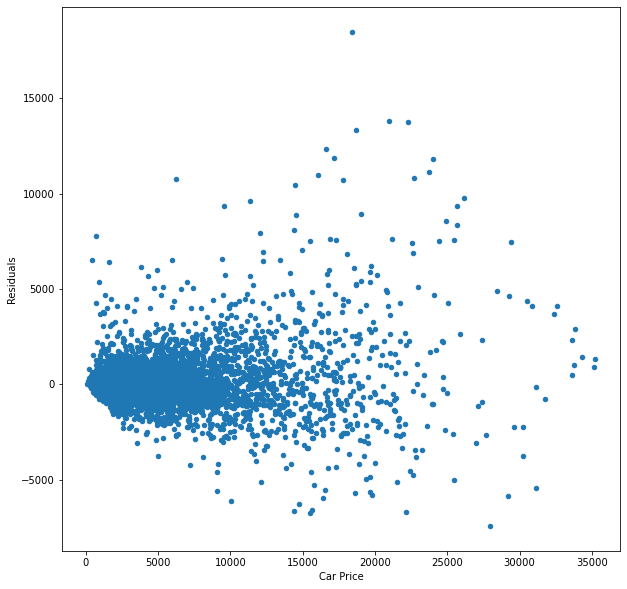

In [63]:
# look at the residuals
results['Residuals'] = results['Actual'] - results['Predicted inverse transformed']
results.plot(x = 'Predicted inverse transformed', y = 'Residuals',kind = 'scatter', figsize=(10,10))
plt.xlabel('Car Price')

In [64]:
# Save the pipeline for feature engineering
features_path = '5. Insights/Models/used_car_prices_feature_engineering.pickle'
with open(features_path, 'wb') as f:
    pickle.dump(feature_engineering, f)

print('The file {} is saved.'.format(features_path))

# Save the pipeline for model
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(pipe, f)

print('The file {} is saved.'.format(model_path))

# Save the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'wb') as f:
    pickle.dump(power_tr, f)
print('The file {} is saved.'.format(transformer_path))

The file 5. Insights/Models/used_car_prices_feature_engineering.pickle is saved.
The file 5. Insights/Models/used_car_prices_model.pickle is saved.
The file 5. Insights/Models/used_car_prices_target_transformation.pickle is saved.


## Ptrediction 

In [65]:
# Load the data
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(prediction_data)

# Load a feature engineering pipeline from a file
features_path = '5. Insights/Models/used_car_prices_feature_engineering.pickle'
with open(features_path, 'rb') as f:
    feature_engineering_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(feature_engineering_loaded))

# Load a model from a file
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'rb') as f:
    regression_model_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(regression_model_loaded))

# Load the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'rb') as f:
    transformer_loaded = pickle.load(f)
print('Transformer {} is loaded.'.format(transformer_loaded))

Regression model Pipeline(steps=[('features', FeatureEngineering())]) is loaded.
Regression model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_power',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer_value',
                                                   'odometer_value/year',
                                                   'durat

In [66]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


### Prediction of car prices

In [67]:
# Create new features
df=feature_engineering_loaded.fit_transform(df)

# Make prediction using the pipeline
prediction = regression_model_loaded.predict(df[features])
prediction

array([-0.93735641, -0.79829305, -0.13150238, ..., -0.47241704,
        1.37953707, -0.68838652])

In [68]:
# Transform predicted price to get the rounded car price in dollars
y_predict_price = transformer_loaded.inverse_transform(prediction.reshape(-1,1))
# Round car price to hundred
y_predict_price_round = np.round(y_predict_price,-2)
# Create a dataframe with results
results = pd.DataFrame( {'Predicted':y_predict_price.reshape(-1),
                         'Predicted rounded':y_predict_price_round.reshape(-1)},
                          index=df.index)

# Form a dataframe with car information and predicted prices
prediction_results = df.join(results)

# Save car information and predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_prediction_data_predicted_price.csv"
prediction_results.to_csv(fl, index=False)

# Save predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_predicted_price.csv"
results.to_csv(fl, index=False)

In [69]:
# Car information and predicted prices
prediction_results

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,name,odometer_value/year,year,other_features,Predicted,Predicted rounded
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114,Renault Megane,15652.0,23,3,1710.310263,1700.0
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67,Peugeot 206,12714.0,21,1,2007.731319,2000.0
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50,Volkswagen Sharan,8600.0,20,1,4065.794798,4100.0
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79,Volvo XC60,20909.0,11,8,10517.636467,10500.0
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74,Mazda 3,15846.0,13,3,5328.350867,5300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,Chrysler,Sebring,automatic,blue,347618,2001,gasoline,False,gasoline,2.4,sedan,False,owned,front,True,False,False,False,False,False,False,False,False,False,81,other,18296.0,19,1,2527.674009,2500.0
7703,Geely,Emgrand 7,automatic,black,9700,2018,gasoline,False,gasoline,2.0,suv,False,owned,front,False,True,False,True,False,True,False,True,True,True,84,other,4850.0,2,6,16511.108211,16500.0
7704,Chrysler,Sebring,automatic,red,111111,2001,gasoline,False,gasoline,2.4,sedan,False,owned,front,True,False,False,False,False,False,False,False,False,False,1,other,5848.0,19,1,2869.269862,2900.0
7705,Ford,EcoSport,mechanical,white,109000,2016,diesel,False,diesel,1.5,suv,False,owned,front,False,False,False,True,False,False,True,True,True,True,2,other,27250.0,4,5,15064.656339,15100.0


In [2]:
# Predicted car prices
results